<a href="https://colab.research.google.com/github/wayoo2019/Time-Series-analysis/blob/main/475_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install statsmodels --upgrade

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(style = 'ggplot')
%matplotlib inline
import seaborn as sns


import statsmodels.api as sm

from statsmodels.tsa.ar_model import ar_select_order, AutoReg
from itertools import product
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
warnings.filterwarnings('ignore')

#Question 1

In [ ]:
air = pd.read_csv('/content/drive/MyDrive/475 Time Series/Project 1/Problem1_DataSet.csv', index_col='Month')
air

,"Miles, in Millions"
Month,
Jan-1964,7.269
Feb-1964,6.775
Mar-1964,7.819
Apr-1964,8.371
May-1964,9.069
...,...
Aug-1970,14.057
Sep-1970,16.234
Oct-1970,12.389


##1.1

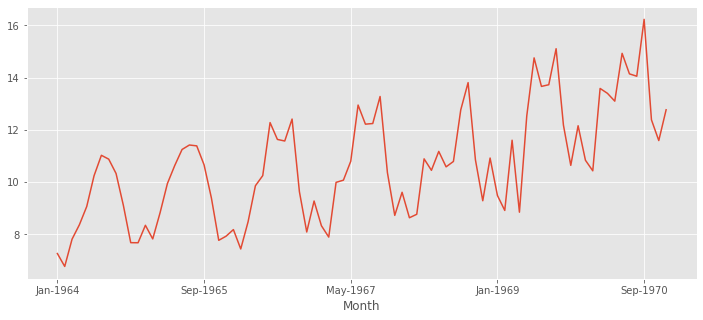

In [ ]:
# plot Time Series
air['Miles, in Millions'].plot(figsize=(12,5))

##1.2

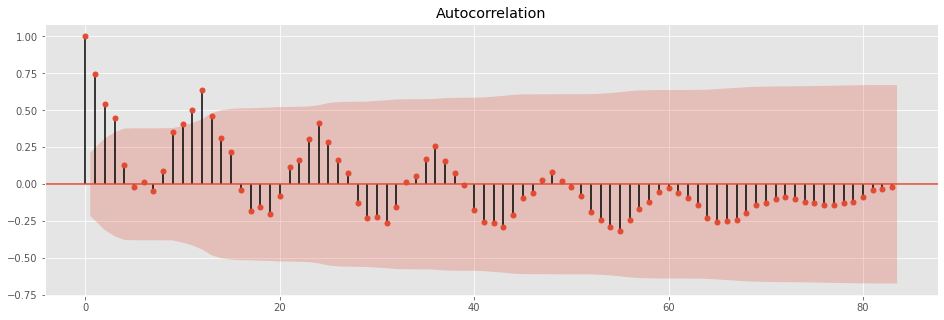

In [ ]:
plt.rc("figure", figsize=(16,5))
sm.graphics.tsa.plot_acf(air, lags=np.arange(len(air)))
plt.show()

The seasonal period is 12 since the duration between two ACF peaks is 12

##1.3

Since the seasonal period is 12, the SMA window = 12

In [ ]:
# compute SMA 12
air['SMA_12'] = air['Miles, in Millions'].rolling(12).mean()

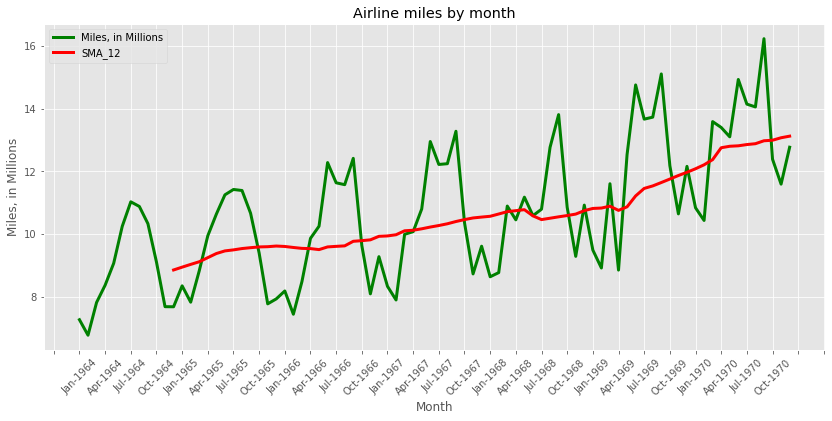

In [ ]:
# plot simple moving average
fig, ax1 = plt.subplots(figsize=(14, 6))
sns.lineplot(x="Month", y="Miles, in Millions", data=air, linewidth=3, color='green' )

ax1.set_title("Airline miles by month")
ax1.set_xlabel("Month")
ax1.set_ylabel("Miles, in Millions")

sns.lineplot(x="Month", y="SMA_12", data=air, linewidth=3, color='red')

ax1.legend(['Miles, in Millions', 'SMA_12']);
ax1.xaxis.set_major_locator(plt.MaxNLocator(36))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()

## 1.4
The trend is increasing


##1.5

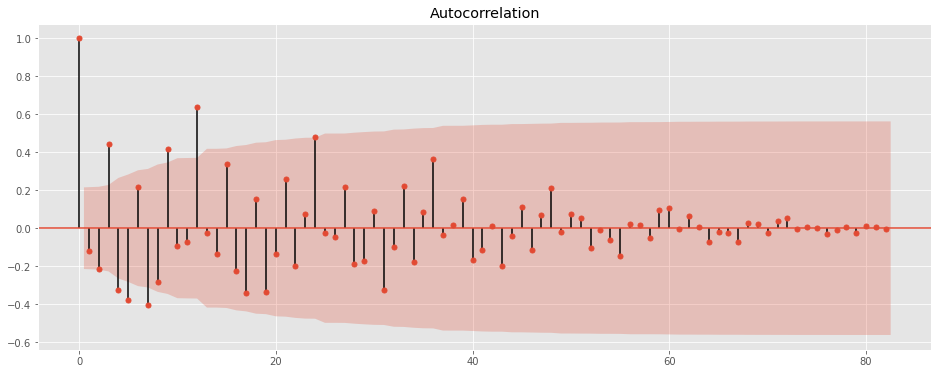

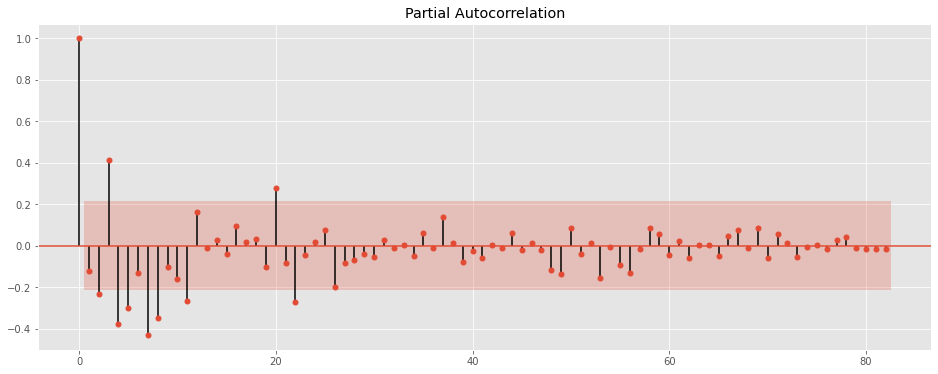

In [ ]:
plt.rc("figure", figsize=(16,6))
sm.graphics.tsa.plot_acf(air["Miles, in Millions"].diff(periods=1).dropna(), lags=np.arange(len(air)-1))
sm.graphics.tsa.plot_pacf(air["Miles, in Millions"].diff(periods=1).dropna(), lags=np.arange(len(air)-1), method="ywm")
plt.show()


*   **ACF**: The significant lags are: 3, 4, 5, 7, 9, 12. It also follows a seasonality period 12.
*   **PACF**: The significant lags are: 3, 4, 5, 7, 8, 11, 20, 22. 



##1.6

In [ ]:
air["1st_diff"] = air["Miles, in Millions"].diff(periods=1)

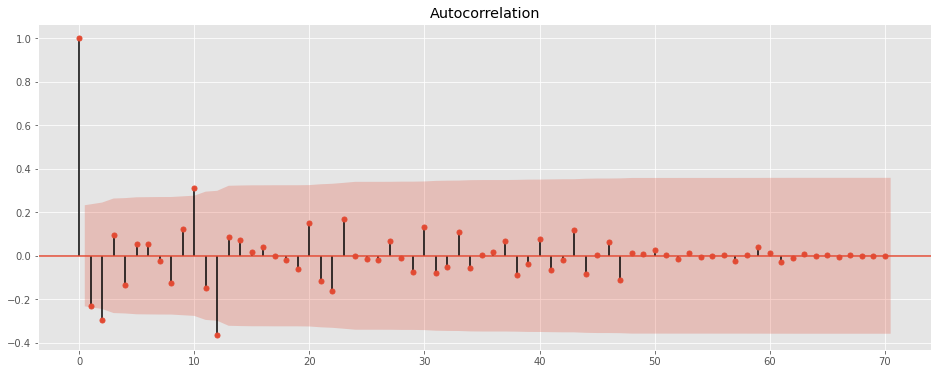

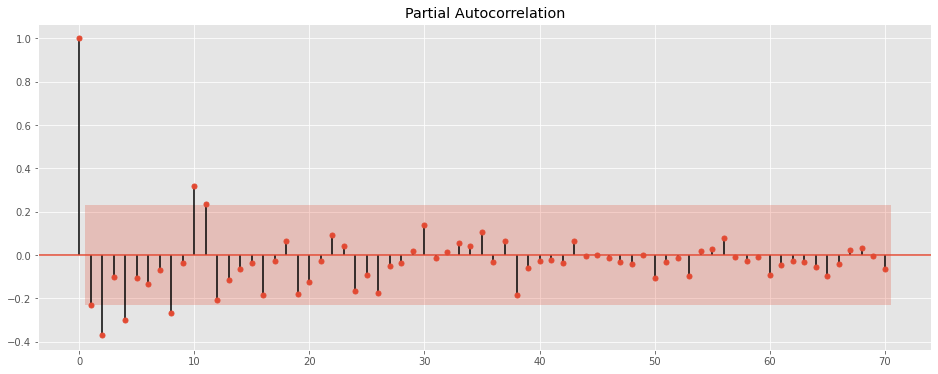

In [ ]:
plt.rc("figure", figsize=(16,6))
sm.graphics.tsa.plot_acf(air["1st_diff"].diff(periods=12).dropna(), lags=np.arange(len(air)-13))
sm.graphics.tsa.plot_pacf(air["1st_diff"].diff(periods=12).dropna(), lags=np.arange(len(air)-13), method="ywm")
plt.show()


*   **ACF**: The significant lags are: 2, 10, 12
*   **PACF**: The significant lags are: 2, 4, 8, 10

## 1.7

Use ADF ti test the 

In [ ]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(air['1st_diff'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.805433859535881
p-value: 7.303107699635809e-12


From the ADF p-value we can conclude that d=1, D=1, so the following SARIMA parameter search will focus on p,q, P,Q and keep d=D=1 constant to reduce the searching range. Also, the seanality S=12 from Q2

In [ ]:
# Define search range while keep d=D=1 constant
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = sm.tsa.statespace.SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, air['Miles, in Millions'][0:72]) # use first 6 years for training
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 1, 0)",147.283319
1,"(2, 3, 0, 1)",147.796097
2,"(0, 2, 1, 0)",148.968651
3,"(0, 2, 0, 1)",149.224977
4,"(2, 3, 2, 0)",149.236374
...,...,...
123,"(0, 0, 1, 1)",167.327523
124,"(1, 0, 3, 1)",168.408457
125,"(0, 0, 3, 0)",168.571740
126,"(0, 0, 2, 1)",168.885846


According to AIC score, the best SARIMA is (2, 1, 3)(1, 1, 0, 12).

In [ ]:
# make sure index is datetime format to SARIMA model
# remove unnecessary columns
air.index = pd.to_datetime(air.index)
air = air.drop(columns='SMA_12', axis=1)
air = air.drop(columns='1st_diff', axis=1)

In [ ]:
model = sm.tsa.statespace.SARIMAX(air,
                                order=(2, 1, 3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                 Miles, in Millions   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(1, 1, 0, 12)   Log Likelihood                 -70.909
Date:                            Tue, 26 Oct 2021   AIC                            155.818
Time:                                    01:50:59   BIC                            170.119
Sample:                                01-01-1964   HQIC                           161.376
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9661      1.173     -0.824      0.410      -3.265       1.332
ar.L2         -0.3701      0.790   

## 1.8

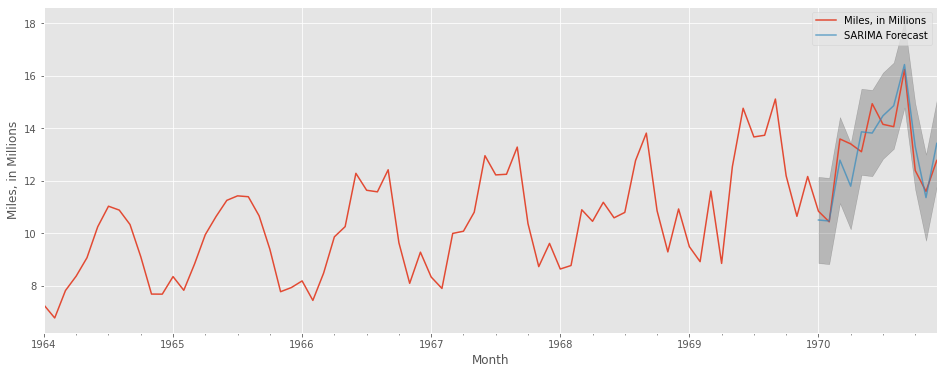

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1970-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = air.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=.7, figsize=(16, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Month')
ax.set_ylabel('Miles, in Millions')
plt.legend()
plt.show()

In [ ]:
table = air[72:]
table['Forecast_mean'] = pred.predicted_mean
table

,"Miles, in Millions",Forecast_mean
Month,,
1970-01-01,10.840,10.504989
1970-02-01,10.436,10.467714
1970-03-01,13.589,12.783808
1970-04-01,13.402,11.791990
1970-05-01,13.103,13.861186
1970-06-01,14.933,13.814956
1970-07-01,14.147,14.473283
1970-08-01,14.057,14.856708
1970-09-01,16.234,16.423232


In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(table['Forecast_mean'], table['Miles, in Millions'])

{'mae': 0.6475241260348731,
 'mape': 0.04853773002552033,
 'me': -0.03660423031746888,
 'mpe': -0.002389047519606603,
 'rmse': 0.7782515381295502}

Around **4.85% MAPE** implies the model is about **95.15%** accurate in predicting the next 12 (month) observations.
However, this model can be improved by adding more criteria for the performance measurement (not only AIC). Also, some other model can be consider to improve the accuracy because different model may good at different situation.

# Problem 2

In [ ]:
wine = pd.read_csv('/content/drive/MyDrive/475 Time Series/Project 1/TotalWine.csv',index_col='Time (Quarter)')
wine

,TotalWine
Time (Quarter),
1,1.486
2,1.915
3,1.844
4,2.808
5,1.287
6,1.861
7,2.034
8,2.739
9,1.656


##2.a

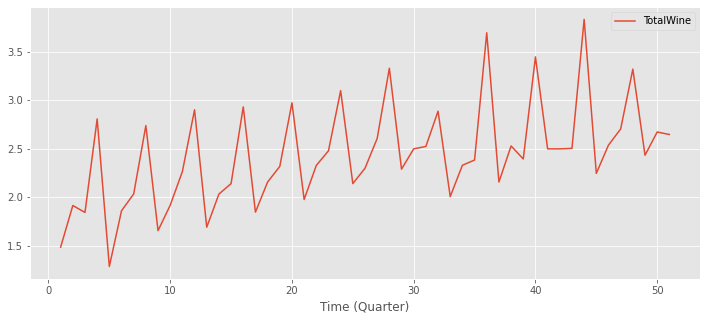

In [ ]:
# plot Time Series
wine.plot(figsize=(12,5))

##2.b

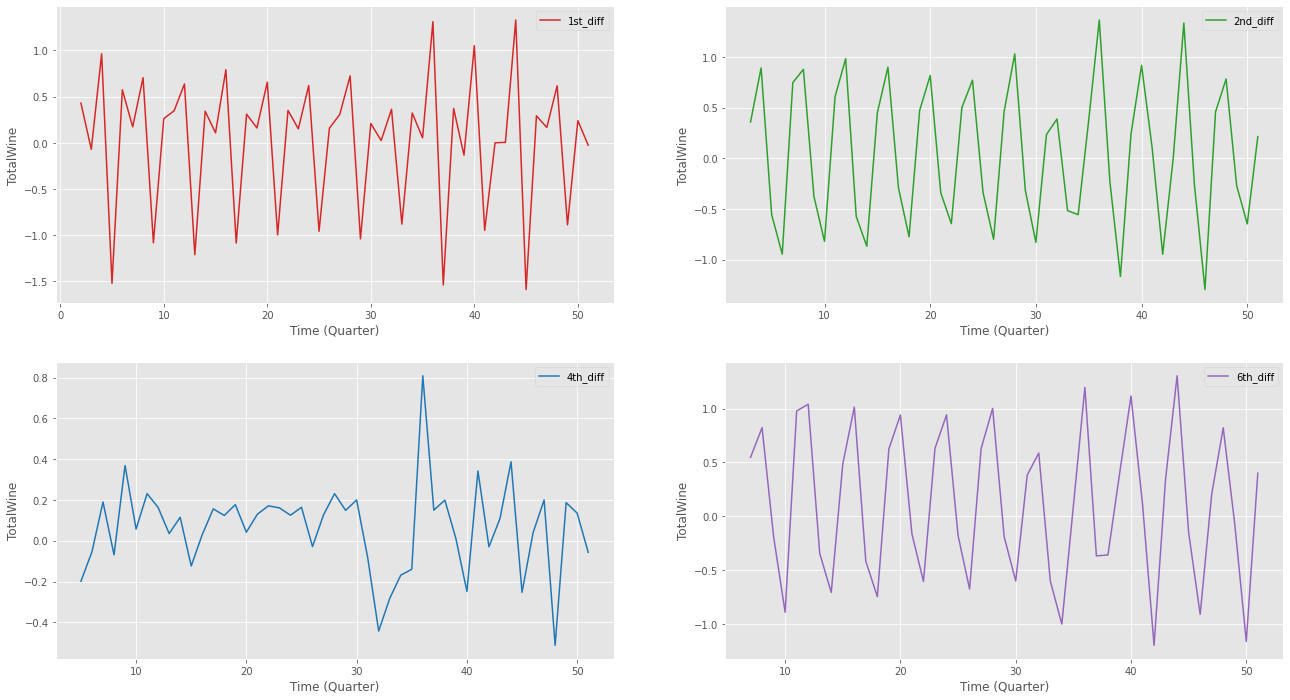

In [ ]:
fig, ax = plt.subplots(2, 2,figsize=[22,12])
sns.lineplot(x = wine.index, y = wine['TotalWine'].diff(periods=1), data = wine, color='tab:red', label='1st_diff',  ax = ax[0,0])
sns.lineplot(x = wine.index, y = wine['TotalWine'].diff(periods=2), data = wine, color='tab:green', label='2nd_diff',  ax = ax[0,1])
sns.lineplot(x = wine.index, y = wine['TotalWine'].diff(periods=4), data = wine, color='tab:blue', label='4th_diff',  ax = ax[1,0])
sns.lineplot(x = wine.index, y = wine['TotalWine'].diff(periods=6), data = wine, color='tab:purple', label='6th_diff',  ax = ax[1,1])
plt.legend()

plt.show()

The 4th order differencing is suitable to remove seasonality

##2.c

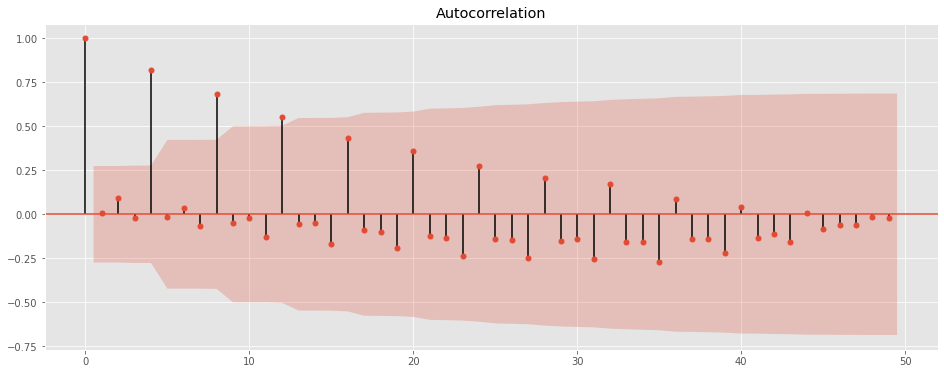

In [ ]:
plt.rc("figure", figsize=(16,6))
sm.graphics.tsa.plot_acf(wine["TotalWine"], lags=np.arange(len(wine)-1))

plt.show()

From the original Time Seires ACF, the significant lags = 4, 8, 12. The seasonality is 4 (same as differencing observation)

##2.d

In [ ]:
model = ar_select_order(wine, maxlag = 10, ic = 'aic', glob = True, old_names = False) 
model.ar_lags

[4, 8]

p could be 4 or 8, while the seasonality = 4

##2.e

AR(4) 

In [ ]:
model_1 = AutoReg(wine.diff(periods=4), 4, missing = 'drop', old_names = False) 
result_1 = model_1.fit() 
print(result_1.summary())

                            AutoReg Model Results                             
Dep. Variable:              TotalWine   No. Observations:                   47
Model:                     AutoReg(4)   Log Likelihood                  15.286
Method:               Conditional MLE   S.D. of innovations              0.170
Date:                Tue, 26 Oct 2021   AIC                            -18.571
Time:                        16:30:36   BIC                             -8.004
Sample:                             4   HQIC                           -14.674
                                   47                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1189      0.031      3.850      0.000       0.058       0.179
TotalWine.L1    -0.0033      0.116     -0.029      0.977      -0.230       0.223
TotalWine.L2     0.0507      0.115      0.44

AR(8)

In [ ]:
model_2 = AutoReg(wine.diff(periods=4), 8, missing = 'drop', old_names = False) 
result_2 = model_2.fit() 
print(result_2.summary())

                            AutoReg Model Results                             
Dep. Variable:              TotalWine   No. Observations:                   47
Model:                     AutoReg(8)   Log Likelihood                  15.615
Method:               Conditional MLE   S.D. of innovations              0.162
Date:                Tue, 26 Oct 2021   AIC                            -11.230
Time:                        16:30:38   BIC                              5.406
Sample:                             8   HQIC                            -5.261
                                   47                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1094      0.045      2.426      0.015       0.021       0.198
TotalWine.L1     0.1266      0.159      0.797      0.425      -0.185       0.438
TotalWine.L2     0.1476      0.152      0.96

According to the AIC, the AR model should be AR(4) with seasonality = 4

In [ ]:
table2 = wine
table2['Forecast_lag4'] = result_1.predict(0) 
table2['Forecast_lag8'] = result_2.predict(0)
table2['diff_4'] = table2['TotalWine'].diff(periods=4)

table2

,TotalWine,Forecast_lag4,Forecast_lag8,diff_4
Time (Quarter),,,,
1,1.486,NaN,NaN,NaN
2,1.915,NaN,NaN,NaN
3,1.844,NaN,NaN,NaN
4,2.808,NaN,NaN,NaN
5,1.287,0.161614,NaN,-0.199
6,1.861,0.002057,NaN,-0.054
7,2.034,0.188274,NaN,0.190
8,2.739,-0.122795,-0.075048,-0.069
9,1.656,0.099673,0.105772,0.369


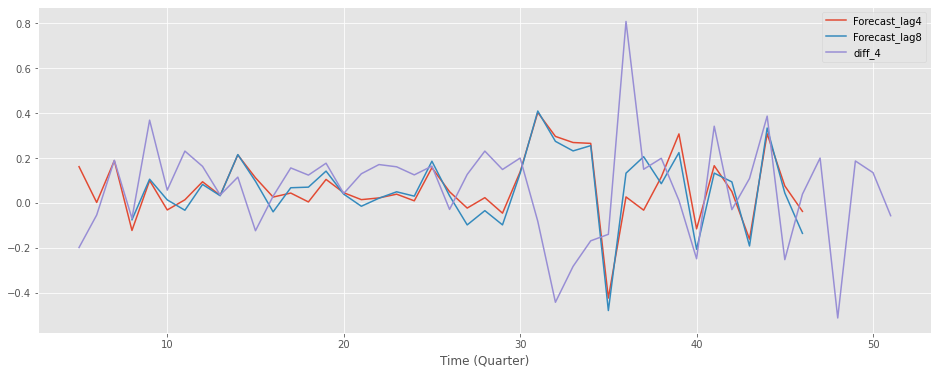

In [ ]:
table2.drop(columns='TotalWine',axis=1).plot(figsize=(16,6))

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):

    mae = np.mean(np.abs(forecast - actual))    # MAE
    return({'mae': mae})

forecast_accuracy(table2['Forecast_lag4'], table2['diff_4'])

{'mae': 0.1892766097493456}